In [1]:
!git clone --depth=1 https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python.git
!pip install filterpy

Cloning into 'Kalman-and-Bayesian-Filters-in-Python'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 170 (delta 5), reused 90 (delta 2), pack-reused 0
Receiving objects: 100% (170/170), 20.11 MiB | 21.38 MiB/s, done.
Resolving deltas: 100% (5/5), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=d55dd17aa4bb4d0f6a8b5caf635c6349ac33930dfa96cbed786fcb257bafb31f
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [2]:
%matplotlib inline

In [3]:
cd /kaggle/working/Kalman-and-Bayesian-Filters-in-Python/

/kaggle/working/Kalman-and-Bayesian-Filters-in-Python


In [4]:
#format the book
import book_format
book_format.set_style()

In [5]:
cd /kaggle/working/Kalman-and-Bayesian-Filters-in-Python/kf_book

/kaggle/working/Kalman-and-Bayesian-Filters-in-Python/kf_book


### 思考実験による直観力の構築

私たちが体重計（立って体重を量る装置）のない世界に住んでいることを想像してみてください。ある日、職場で同僚があなたに駆け寄ってきて、「秤」の発明について発表しました。彼女が説明した後、あなたは熱心にその上に立ち、「172 ポンド」という結果を発表します。あなたは有頂天になります - 人生で初めて自分の体重を知ります。さらに重要なのは、このデバイスを世界中の減量クリニックに販売することを想像すると、ドル記号が目に浮かびます。これは素晴らしいです！

騒ぎを聞きつけた別の同僚がやって来て、あなたが何をそんなに興奮しているのかを知りました。あなたは発明について説明し、もう一度体重計に乗り、結果を誇らしげに宣言します。「161ポンド」。そしてあなたは躊躇し、混乱します。

「数秒前に172ポンドと表示されました」と同僚に愚痴をこぼします。

「私はそれが正確であるとは決して言いませんでした」と彼女は答えた。

センサーが不正確です。これがフィルタリングにおける膨大な作業の背後にある動機であり、この問題を解決することが本書の主題です。過去半世紀にわたって開発されたソリューションを提供することもできますが、これらのソリューションは、私たちが知っていることの性質とそれをどのように知るかについて、非常に基本的かつ根本的な質問をすることによって開発されました。数学を試す前に、その発見の旅をたどり、それがフィルタリングについての直感に役立つかどうかを確認してみましょう。

### 別のスケールを試してみる

この結果を改善する方法はあるでしょうか?当然のことですが、最初に試すべきことは、より優れたセンサーを入手することです。残念なことに、あなたの同僚は、10 台の体重計を作成したと報告しましたが、それらはすべてほぼ同じ精度で動作します。あなたは彼女に別の体重計を持ってきてもらい、一方の体重計で体重を量り、次にもう一方の体重計で体重を量ります。最初のスケール (A) は「160 ポンド」、2 番目のスケール (B) は「170 ポンド」と表示されます。あなたの体重についてどのような結論が得られますか?

さて、私たちの選択は何でしょうか？

A のみを信じて、推定体重に 160 ポンドを割り当てることもできます。
B だけを信じて、自分の体重に 170 ポンドを割り当てることもできます。
A と B の両方より小さい数を選択することもできます。
A と B の両方より大きい数値を選択することもできます。
A と B の間で数字を選択できます。

最初の 2 つの選択肢はもっともらしいですが、一方のスケールをもう一方のスケールよりも優先する理由はありません。なぜ私たちはBではなくAを信じることを選ぶのでしょうか?私たちがそのような信念を持つ理由はありません。 3 番目と 4 番目の選択肢は非合理的です。確かにスケールはそれほど正確ではありませんが、両方が測定した範囲外の数値を選択する理由はまったくありません。最終的な選択が唯一合理的な選択です。両方の体重計が不正確で、実際の体重を上回るか下回る結果が得られる可能性が高い場合、多くの場合、答えは A と B の間のどこかになります。

数学では、この概念は期待値として形式化されており、後で詳しく説明します。ここで、100 万回の読み取りを行った場合に「通常の」何が起こるかを自問してください。両方の秤の測定値が低すぎる場合もあれば、両方の測定値が高すぎる場合もあり、残りの場合は実際の重量にまたがります。実際の重量にまたがっている場合は、A と B の間の数値を選択する必要があります。またがっていない場合は、両方とも高すぎるか低すぎるかはわかりませんが、A と B の間の数値を選択することで、最悪の測定値の影響を最小限に抑えます。たとえば、実際の体重が 180 ポンドだとします。 160ポンドは大きな誤差です。ただし、160 ポンドと 170 ポンドの間の重量を選択した場合、推定値は 160 ポンドよりも良くなります。両方の秤が実際の重量より大きい値を返した場合にも、同じ議論が当てはまります。

これについては後ほど正式に扱いますが、今のところ、最良の推定値が A と B の平均であることが明らかであることを願っています。

$$
\frac{160 + 170}{2} = 165
$$

これをグラフで見てみましょう。 8 ポンドの誤差を想定して A と B の測定値をプロットしました。測定値は 160 ～ 170 ポンドの間であるため、意味のある唯一の重量は 160 ～ 170 ポンド以内でなければなりません。

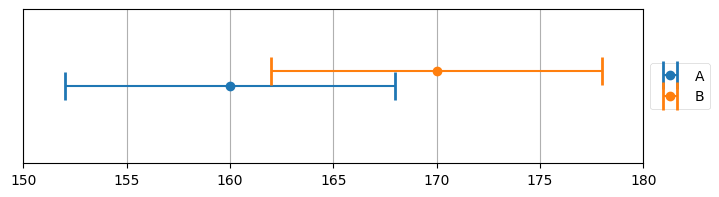

In [6]:
import kf_book.book_plots as book_plots
from book_plots import plot_errorbars

plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))

このプロットをどのように作成したかについて一言。 kf_book サブディレクトリにあるモジュール book_plots からコードをインポートします。このプロットを生成するには、読んでも面白くない定型的な Python が大量に必要になります。私は本の中でこの考え方をよく取り上げています。セルが実行されると、plot_errorbars() が呼び出され、プロットがブックに挿入されます。

Jupyter Notebook を初めて使用する場合、上記のコードはセル内にあります。 「In [2]:」というテキストは、入力を入力できるセルとしてこれをラベル付けし、括弧内の数字は、このセルが 2 番目に実行されたことを示します。セルを実行するには、セルをクリックしてフォーカスを置き、キーボードの CTRL+ENTER を押します。続行すると、セル内のコードを変更して再実行できるようになります。値「160」、「170」、「8」を他の値に変更してセルを実行してみてください。入力した内容に応じて印刷出力が変わるはずです。

Lot_errorbars のコードを表示したい場合は、エディターでコードを開くか、新しいセルを作成して関数名とその後に 2 つの疑問符を入力します。 Ctrl+Enter を押すと、ブラウザでウィンドウが開き、ソース コードが表示されます。これは Jupyter Notebook の機能です。関数のドキュメントを参照するだけの場合は、疑問符を 1 つ付けて同じ操作を行います。

plot_errorbars??

または

plot_errorbars?

したがって、165 ポンドは妥当な推定値のように見えますが、活用できる可能性のある詳細情報がここにあります。可能な重量は、A と B のエラーバー間の交点にあるのみです。たとえば、スケール B では最大誤差 8 ポンドで 170 ポンドの読み取り値が得られないため、161 ポンドの重量は不可能です。同様に、スケール A では最大誤差 8 ポンドで 160 ポンドの読み取り値が得られないため、169 ポンドの重量は不可能です。この例では、可能な重量は 162 ～ 168 ポンドの範囲のみです。

まだ、より適切な重量推定値を見つけることはできませんが、「もしも」をもう少し考えてみましょう。 A が B よりも 3 倍正確であると言われたらどうなるでしょうか?上に挙げた 5 つのオプションを検討してください。 A と B の範囲外の数値を選択しても意味がありませんので、それらは考慮しません。おそらく、推定値として A を選択する方が説得力があるように思えます。結局のところ、A の方が正確であることがわかっているのに、B の代わりに A を使用しないのはなぜでしょうか。 B は A 単独よりも知識を向上させることができるでしょうか?

おそらく直感に反するかもしれない答えは、「はい、可能です」です。まず、A=160 と B=170 の同じ測定値を見てみましょう。ただし、A には誤差があります。
3ポンドとBの誤差は3倍の9ポンドです。

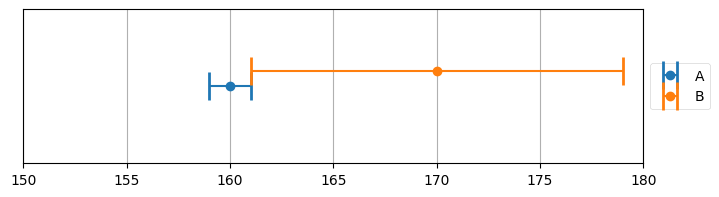

In [7]:
plot_errorbars([(160, 1, 'A'), (170, 9, 'B')], xlims=(150, 180))

ここでは、可能な重量は 161 ポンドのみであることがわかります。これは重要な結果です。 2 つの比較的不正確なセンサーを使用して、非常に正確な結果を推定することができます。

したがって、センサーが 2 つある場合は、1 つがもう 1 つより精度が低くても、1 つよりも優れています。この本の残りの部分では、これについてハープしていきます。どんなに貧弱な情報であっても、私たちは決して捨てません。私たちは、考えられるすべての情報源を含めて可能な限り最良の推定値を作成できるようにする数学とアルゴリズムを開発する予定です。

しかし、私たちは問題からそれてしまいました。複数の体重計を購入したい顧客はいないでしょうし、それに加えて、私たちは当初、すべての体重計が同等（不正確）であるという仮定から始めました。精度に関係なくすべての測定値を使用するというこの洞察は、後で大きな役割を果たすため、忘れないでください。

体重計は 1 つしかないのに、何度も体重を量ったらどうなるでしょうか?同じ精度の 2 つのスケールがある場合、それらの測定結果を平均する必要があると結論付けました。 1 台の体重計で 10,000 回体重を計ったらどうなるでしょうか?スケールが大きすぎる数値を返す可能性と、小さすぎる数値を返す可能性が同じであることはすでに述べました。多数の重みの平均が実際の重みに非常に近いことを証明するのはそれほど難しいことではありませんが、とりあえずシミュレーションを書いてみましょう。数値計算には SciPy エコシステムの一部である NumPy を使用します。

In [8]:
import numpy as np
measuraments = np.random.uniform(160, 170, size=10000)

mean=measuraments.mean()
print(f'Average of measuraments is {mean:4f}')

Average of measuraments is 165.025364


出力される正確な数値は乱数ジェネレーターによって異なりますが、165 に非常に近いはずです。

このコードは、おそらく真実ではない 1 つの仮定を立てています。つまり、実際の重量が 165 ポンドの場合、スケールの読み取り値は 160 である可能性が 165 である可能性が高いということです。これはほとんど真実ではありません。実際のセンサーは、真の値に近い読み取り値を取得する可能性が高く、真の値から離れるほど読み取り値を取得する可能性が低くなります。これについてはガウスの章で詳しく説明します。ここでは、これ以上の説明はせずに numpy.random.normal() 関数を使用します。この関数は、165 ポンドに近づくとより多くの値を生成し、165 ポンドから離れるとより少ない値を生成します。現時点では、これにより実際のスケールの動作と同様のノイズの多い測定値が生成されることを信じてください。

In [9]:
mean = np.random.normal(165, 5, size=10000).mean()
print(f'Average of measuraments is {mean:.4f}')

Average of measuraments is 164.9109


繰り返しますが、答えは 165 に非常に近いです。

よし、素晴らしい。センサーの問題に対する答えが見つかりました。しかし、それはあまり現実的な答えではありません。自分の体重を1万倍、さらには12倍にする忍耐力のある人は誰もいません。

それでは、「もしも」をプレイしてみましょう。 1 日に 1 回体重を測定し、測定値が 170、161、そして 169 になった場合はどうなるでしょうか。体重が増えたのでしょうか、減ったのでしょうか、それとも、これはすべてただのノイズの多い測定値なのでしょうか?

本当に何とも言えません。最初の測定値は 170、最後の測定値は 169 で、1 ポンドの減少を意味します。しかし、スケールが 10 ポンドまでしか正確でない場合、それはノイズによって説明可能です。実際に体重が増えた可能性もあります。おそらく初日の体重は 165 ポンドで、3 日目には 172 ポンドでした。その体重増加でそれらの体重測定値を取得することは可能です。体重計では体重が減っていると表示されていますが、実際には体重が増えています。それをグラフで見てみましょう。測定値をエラーバーとともにプロットし、それらの測定値によって説明できる可能性のある体重増加/減少を緑の点線でプロットしました。

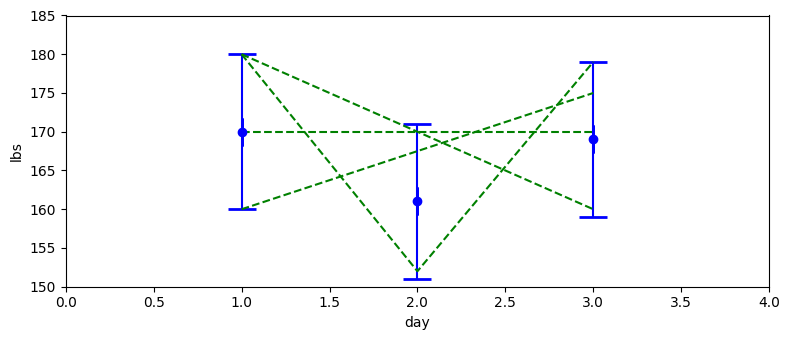

In [10]:
import kf_book.gh_internal as gh
gh.plot_hypothesis1()

ご覧のとおり、これら 3 つの測定値によって説明できる極端な範囲の体重変化があります。実際、選択肢は無限にあります。諦めましょうか？私じゃない！人間の体重の測定について話していることを思い出してください。人間の体重が 1 日目に 180 ポンド、3 日目に 160 ポンドになることや、1 日で 30 ポンド体重が減って次の日には元に戻るという合理的な方法はありません (切断やその他の外傷が身体に起こっていないと仮定します)。人）。

私たちが測定している物理システムの動作は、測定値をどのように解釈するかに影響を与えるはずです。もし私たちが毎日岩石の重さを量っていたら、すべての変動はノイズのせいだと考えてしまうでしょう。雨によって養われ、家事に使用される水槽の重量を量っていたら、そのような重量の変化は本物だと信じるかもしれません。

別のスケールを使用して、次の測定値が得られたとします: 169、170、169、171、170、171、169、170、169、170。あなたの直感は何を言いますか?たとえば、毎日 1 ポンド増加したのに、ノイズの多い測定値がたまたま同じ体重のままであるように見える可能性があります。同様に、1 日あたり 1 ポンド減量しても同じ測定値が得られた可能性があります。しかし、その可能性はあるでしょうか？コインを投げて 10 回連続で表が出る確率はどのくらいですか?あまり可能性は高くありません。これらの測定値のみに基づいてそれを証明することはできませんが、私の体重は一定に保たれていた可能性がかなり高いと思われます。下のグラフでは、測定値を誤差バーでプロットし、おそらく真の重量を緑色の点線でプロットしました。この破線は、この問題に対する「正しい」答えを意味するものではなく、単に合理的であり、測定によって説明できるものにすぎません。

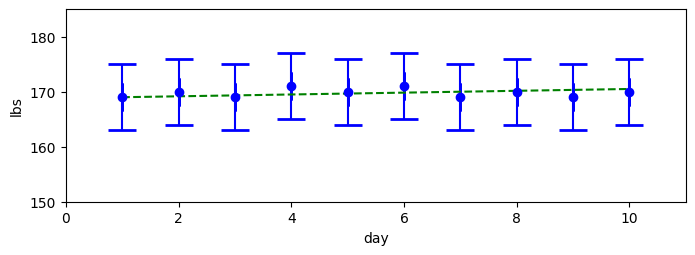

In [11]:
gh.plot_hypothesis2()

もう 1 つの仮定: 測定値が 158.0、164.2、160.3、159.9、162.1、164.6、169.6、167.4、166.4、171.0 だったらどうなるでしょうか?そのグラフを見て、いくつかの質問に答えてみましょう。

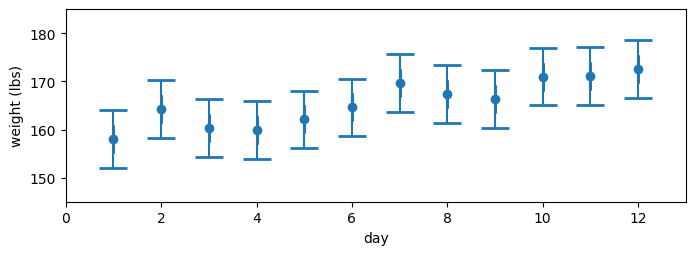

In [12]:
gh.plot_hypothesis3()

私が体重を減らしたように「見える」のですが、これは単なるノイズの多いデータでしょうか?あまり。おそらく私も同じ体重だったのではないでしょうか？繰り返しますが、いいえ。このデータは時間の経過とともに増加する傾向にあります。均等ではありませんが、確実に上向きです。確かなことはできませんが、体重が大幅に増加しているようです。この仮定をさらにいくつかのプロットでテストしてみましょう。多くの場合、表よりもグラフの方がデータを「注目」するのが簡単です。

そこで、2 つの仮説を見てみましょう。まず、体重が変わらなかったと仮定します。この数値を取得するには、測定値を平均する必要があることに同意しました。それを見てみましょう。

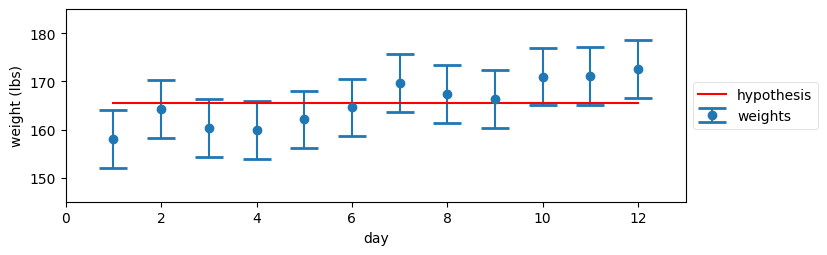

In [13]:
gh.plot_hypothesis4()

それはあまり説得力がありません。実際、すべての誤差範囲内にある水平線を引くことはできないことがわかります。

さて、体重が増えたとしましょう。いくら？わかりませんが、NumPy は知っています。測定結果から「およそ」正しく見える線を引きたいと考えています。 NumPy には、「最小二乗適合」と呼ばれるルールに従ってこれを行う関数があります。計算の詳細については気にせず (興味があれば、polyfit() を使用します)、結果をプロットするだけにしてみましょう。

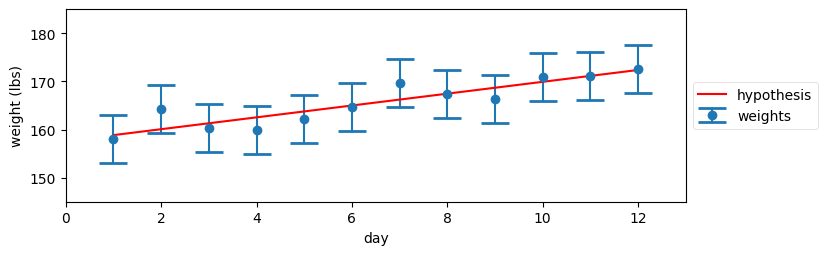

In [14]:
gh.plot_hypothesis5()

少なくとも私の目には、この方がはるかに良く見えます。ここで、仮説が各測定値の非常に近くにあることに注目してください。一方、前のプロットでは、仮説は測定値からかなり離れていることがよくありました。体重が増えなかったというよりも、体重が増えたというほうが真実である可能性がはるかに高いようです。実際に13ポンド増えたでしょうか？誰が言えるの？それは答えるのが不可能のようです。

「でもそれは不可能ですか？」同僚にパイプをする。

クレイジーなことを試してみましょう。 1 日に約 1 ポンドずつ体重が増えていることがわかっていると仮定しましょう。今それをどのように知っているかは問題ではありません。それがほぼ正しいと知っていると仮定してください。おそらく私は1日6000カロリーのダイエットをしているので、これほど体重が増加するでしょう。あるいは、体重増加を推定する別の方法があるかもしれません。これは思考実験であり、詳細は重要ではありません。そのような情報が利用可能であれば、それを利用できるかどうかを見てみましょう。

最初の測定値は 158 でした。それ以外を知る方法はないので、これを推定値として受け入れましょう。今日の体重が 158 なら、明日は何になるでしょうか?さて、体重は 1 日あたり 1 ポンド増加していると考えられるため、予測は次のように 159 になります。

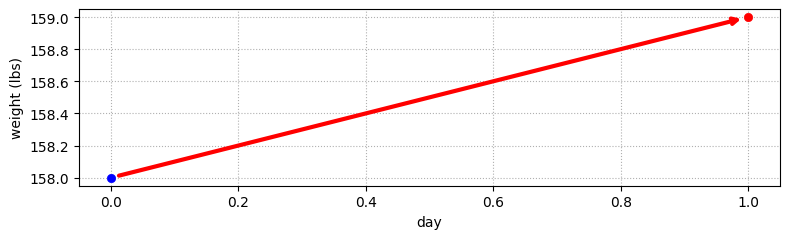

In [15]:
gh.plot_estimate_chart_1()

わかったけど、これって何の役に立つの？確かに、1 ポンド/日が正確であると仮定して、次の 10 日間の体重を予測することはできますが、その測定値を組み込んでいないのに、そもそも体重計を使用する必要はありません。それでは、次の測定を見てみましょう。もう一度体重計に乗ると、164.2ポンドと表示されます。

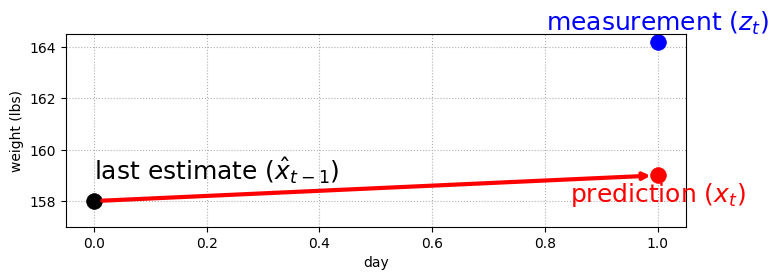

In [16]:
gh.plot_estimate_chart_2()

問題があります。私たちの予測は測定値と一致しません。しかし、それは私たちが期待していたものですよね？予測が常に測定値とまったく同じである場合、フィルターに情報を追加することはできません。そしてもちろん、私たちの予測は完璧なので、測定する理由はありません。

この本全体に対する重要な洞察は次の段落にあります。よく読んでください！

### どうしようか？
- 測定値から推定値を作成するだけの場合、予測は結果に影響しません。予測から推定値を作成するだけの場合、測定値は無視されます。これが機能するためには、予測と測定を何らかの形で組み合わせる必要があります (重要な点を太字にしました)。

### 2 つの値をブレンドする 
- これは、前述の 2 つのスケールの問題によく似ています。前と同じ推論を使用すると、意味のある唯一のことは、予測と測定の間で数値を選択することであることがわかります。たとえば、165 という推定値は意味がありません。157 も意味がありません。推定値は 159 (予測) と 164.2 (測定値) の間にある必要があります。

**もう一度言いますが、これは非常に重要です。私たちは、誤差のある 2 つの値が提示された場合、2 つの値の間の途中で推定値を作成する必要があることに同意しました。**

これらの値がどのように生成されたかは関係ありません。この章の最初では 2 つの測定値がありましたが、現在は 1 つの測定値と 1 つの予測値になっています。どちらの場合でも、推論、つまり数学は同じです。私たちは情報を決して捨てません。私は真剣です。ノイズの多いデータを破棄する商用ソフトウェアがたくさんあります。やめてください！**体重増加の予測はあまり正確ではないかもしれませんが、何らかの情報がある限りそれを使用する必要があります。**

立ち止まって真剣に考えてみてください。私がやったことは、不正確な体重計を人間の生理学に基づいた不正確な体重予測に置き換えただけです。やはりデータです。数学では、データがスケールから来たのか、それとも予測から来たのかはわかりません。ある程度のノイズを含む 2 つのデータがあり、それらを結合したいと考えています。この本の残りの部分では、この計算を実行するためのかなり複雑な数学を開発していきますが、数学ではデータがどこから来たのかはまったく気にされず、それらの値の値と精度に基づいて計算が行われるだけです。

推定値は測定値と予測値の中間にあるべきですか?おそらくですが、一般的には、測定値と比較して予測が多かれ少なかれ正確であることがわかっているようです。おそらく、私たちの予測の精度はスケールの精度とは異なります。スケール A がスケール B よりもはるかに正確だったときに行ったことを思い出してください。答えを B よりも A に近くなるようにスケールしました。これをグラフで見てみましょう。

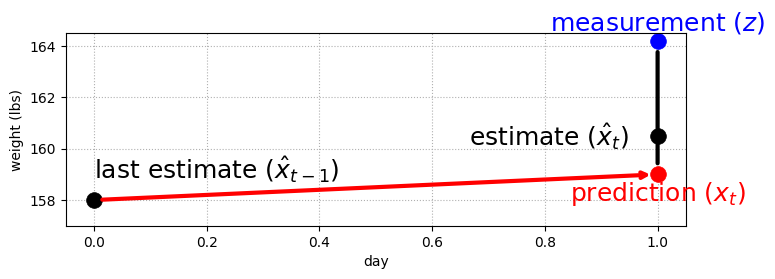

In [17]:
gh.plot_estimate_chart_3()

次に、ランダムに選択した数値を試して推定値をスケールしてみましょう。

。私たちの推定値は測定値の 10 分の 4 で、残りは予測に基づくものになります。言い換えれば、ここでは信念、つまり予測の方が測定よりも正しい可能性がいくらか高いという信念を表現しているのです。それを次のように計算します

$$
estimate = prediction + \frac{4}{10}(measurement- prediction)
$$

測定値と予測値の差は残差と呼ばれ、上のプロットでは黒い縦線で示されています。これは測定値とフィルターの出力の差を正確に計算したものであるため、後で使用する重要な値になります。残差が小さいほど、パフォーマンスが向上することを意味します。

これをコーディングして、上記の一連の重みに対してテストした結果を見てみましょう。もう 1 つの要素を考慮する必要があります。体重増加の単位はポンド/時間なので、一般的には時間ステップtを追加する必要があります。

、これを 1 (日) に設定します。

私は、実際の開始体重 160 ポンドと 1 日あたり 1 ポンドの体重増加に対応する体重データを手動で生成しました。つまり、初日 (0 日目) の真の体重は 160 ポンド、2 日目 (1 日目、計量初日) の真の体重は 161 ポンド、というようになります。

初期重量を推測する必要があります。初期化戦略について話すのは時期尚早なので、今のところは 160 ポンドを想定します。

In [18]:
from kf_book.book_plots import figsize
import matplotlib.pyplot as plt

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6,
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1.0
scale_factor = 4.0/10

def predict_using_gain_guess(estimated_weight, gain_rate, do_print=False):
    # フィルターした結果を保存する
    estimates, predictions = [estimated_weight], []
    
    # 多くのフィルターに関する文献ではzを測定した観測値を表す
    for z in weights:
        # 新しい値を予測する
        predicted_weight = estimated_weight + gain_rate*time_step
        
        # フィルターの更新
        estimated_weight = predicted_weight + scale_factor* (z- predicted_weight)
        
        # 結果を保存しログをとる
        estimates.append(estimated_weight)
        predictions.append(predicted_weight)
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)
            
    return estimates, predictions

initial_estimate = 160
estimates, predictions = predict_using_gain_guess(
    estimated_weight=initial_estimate, gain_rate=1, do_print=True)

previous estimate: 160.00, prediction: 161.00, estimate 159.80
previous estimate: 159.80, prediction: 160.80, estimate 162.16
previous estimate: 162.16, prediction: 163.16, estimate 162.02
previous estimate: 162.02, prediction: 163.02, estimate 161.77
previous estimate: 161.77, prediction: 162.77, estimate 162.50
previous estimate: 162.50, prediction: 163.50, estimate 163.94
previous estimate: 163.94, prediction: 164.94, estimate 166.80
previous estimate: 166.80, prediction: 167.80, estimate 167.64
previous estimate: 167.64, prediction: 168.64, estimate 167.75
previous estimate: 167.75, prediction: 168.75, estimate 169.65
previous estimate: 169.65, prediction: 170.65, estimate 170.87
previous estimate: 170.87, prediction: 171.87, estimate 172.16


[158.0,
 164.2,
 160.3,
 159.9,
 162.1,
 164.6,
 169.6,
 167.4,
 166.4,
 171.0,
 171.2,
 172.6]

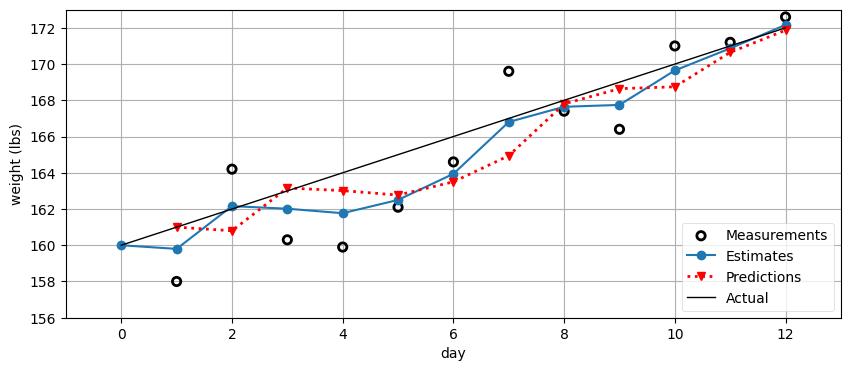

In [19]:
book_plots.set_figsize(10)
gh.plot_gh_results(weights, estimates, predictions, [160, 172])
weights

それはかなり良いですね！ここには大量のデータがあるので、それをどのように解釈するかについて話しましょう。青い太い線はフィルターからの推定値を示します。最初の推定体重は 160 ポンドで、0 日目から始まります。赤い線は前日の体重からの予測を示しています。したがって、1 日目の以前の体重は 160 ポンドで、体重増加は 1 ポンドであるため、最初の予測は 161 ポンドになります。 1 日目の推定値は 159.8 ポンドで、予測と測定の間の中間になります。グラフの下には、毎日の以前の体重、予測体重、新しい推定値が印刷されています。最後に、細い黒い線は、体重を測定される人の実際の体重増加を示します。

これを毎日確認して、各ステップで予測と推定がどのように形成されたかを確実に理解してください。推定値が常に測定値と予測値の間にあることに注目してください。

推定値は直線ではありませんが、測定値よりも直線であり、作成した傾向線にいくらか近くなっています。また、時間の経過とともに改善されるようです。

フィルタの結果は非常にばかげているように思えるかもしれません。もちろん、体重増加が 1 日あたり約 1 ポンドであるという結論を仮定すると、データは良好に見えます。最初の推測が間違っていた場合にフィルターが何をするかを見てみましょう。 1 日に 1 ポンドの体重減少があると予測してみましょう。

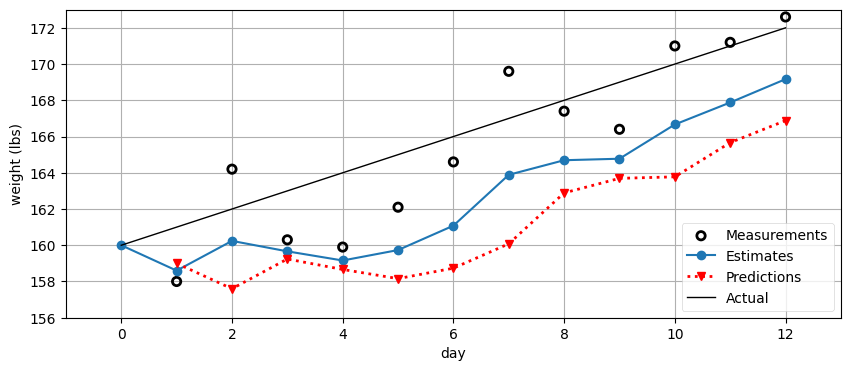

In [20]:
e, p = predict_using_gain_guess(initial_estimate, -1)
gh.plot_gh_results(weights, e, p, [160, 172])

それはそれほど印象的ではありません。推定値はすぐに測定値から逸脱します。明らかに、変化率を正確に推測する必要があるフィルターはあまり役に立ちません。たとえ最初の推測が正しかったとしても、その変化率が変化するとすぐにフィルターは失敗します。過食をやめると、フィルターがその変化に適応するのが非常に難しくなります。調整中ですのでご了承ください！ 1日あたり1ポンドずつ体重が減っていくと言っているにもかかわらず、その推定値は上昇しています。ただ十分に速く調整することができません。

しかし、「もしも」？体重増加を最初の推定 1 ポンド (またはその他) のままにする代わりに、既存の測定値と推定値から計算したらどうなるでしょうか。初日の推定体重は次のとおりです。

$$
(160 + 1) + \frac{4}{10}(158-161)=159.8
$$

翌日の測定値は 164.2 で、これは体重が 1 ではなく 4.4 ポンド増加したことを意味します (164.2 - 159.8 = 4.4 であるため)。この情報を何らかの方法で使用できますか?それはもっともらしいです。結局のところ、体重測定自体は実際の体重測定に基づいているため、有益な情報があります。体重増加の推定は完璧ではないかもしれませんが、単に体重増加が 1 ポンドであると推測するよりは確実に優れています。たとえノイズが多くても、データは推測よりも優れています。

この時点で人々は本当に躊躇するので、同意していることを確認してください。**ノイズの多い 2 つの体重測定値から、暗黙の体重増加/減少が得られます。測定値が不正確であれば、その推定値は非常に不正確になりますが、この計算にはまだ情報が含まれています。** 1 ポンドまで正確な体重計で牛の体重を量ると、牛が 10 ポンド増加したことがわかります。誤差によっては、牛の体重は 8 ポンドから 12 ポンドまで増加した可能性がありますが、体重がどのくらい増加したかはわかっています。これは情報です。情報をどうするのか?絶対に捨てないでください！

私の食生活に戻ります。 1 日あたりの新しい増加量を 4.4 ポンドに設定する必要がありますか?昨日は体重増加が 1 ポンドだと思っていましたが、今日は 4.4 ポンドだと思います。 2 つの数字があるので、それらを何らかの方法で組み合わせたいと考えています。うーん、また同じ問題のようですね。同じツール、そしてこれまでに持っている唯一のツールを使用してみましょう - 2 つの中間の値を選択します。今回は別の任意の番号1/3を使用します。
。方程式は体重推定の場合と同じですが、これは割合 (1 日あたりの増加量) であるため、時間を組み込む必要があります。

$$
new gain = old gain + \frac{1}{3}\frac{measurement - predicted weight}{1day}
$$


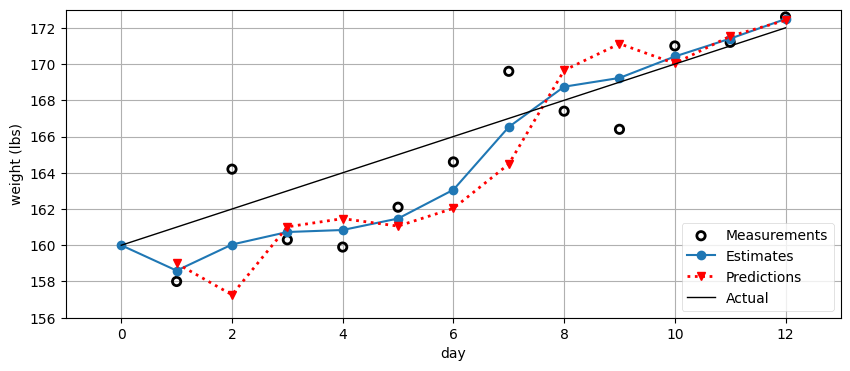

In [21]:
weight = 160
gain_rate = -1.0

time_step = 1
weight_scale = 4./10
gain_scale = 1./3
estimates = [weight]
predictions = []

for z in weights:
    # 予測ステップ
    # 予測したweightをpredictionsというリストに追加
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    predictions.append(weight)
    
    # 更新ステップ
    residual = z - weight
    
    gain_rate = gain_rate + gain_scale   * (residual/time_step)
    weight    = weight    + weight_scale * residual
    
    estimates.append(weight)
    
gh.plot_gh_results(weights, estimates, predictions, [160, 172])

これは本当に良くなり始めていると思います。体重増加の初期推定値が -1 であるため、フィルターが体重を正確に予測するには数日かかりますが、予測が完了すると、体重を正確に追跡し始めます。 $\frac{4}{10}$ と $\frac{1}{3}$ のスケーリング係数を選択するための方法論は使用しませんでしたが（実際、これらはこの問題にとって不適切な選択です）、それ以外の場合はすべての計算が行われました。非常に合理的な仮定から。プロットが段階的に描画されるのを確認したい場合は、パラメーター time_step の値をより大きな値に変更してセルを再実行できることを思い出してください。

次に進む前に、最後にもう 1 つポイントがあります。予測ステップで次の行を書きました
$$
\text { ゲインレート }=\text { ゲインレート }
$$

これは明らかに効果がないため、削除できます。これを書いたのは、予測ステップではすべての変数 (weight と Gain_rate の両方) の次の値を予測する必要があることを強調するためです。これはすぐに関連するものになります。この場合、ゲインは変化しないと仮定していますが、このアルゴリズムを一般化するときは、その仮定を削除します。

### g-hフィルター

このアルゴリズムは、$g$-h フィルターまたは $\alpha$ - $\beta$ フィルターとして知られています。 $g$ と $h$ は、この例で使用した 2 つのスケーリング係数を指します。 $g$ は測定に使用したスケーリング (この例では体重)、$h$ は時間の経過に伴う測定値の変化のスケーリング (この例ではポンド/日) です。 $\alpha$ と $\beta$ は、この要素に使用される別の名前にすぎません。

このフィルターは、カルマン フィルターを含む膨大な数のフィルターの基礎となります。言い換えれば、カルマン フィルターは $\mathrm{g}$-h フィルターの一種であり、これについては本書の後半で証明します。聞いたことがあるかもしれない最小二乗フィルターや、おそらく聞いたことがないかもしれないベネディクト・ボードナーフィルターも同様です。各フィルターは $g$ と $h$ に値を割り当てる方法が異なりますが、それ以外のアルゴリズムは同じです。たとえば、Benedict-Bordner フィルターは、特定の値の範囲に制限された定数を $g$ と $h$ に割り当てます。カルマンなどの他のフィルターは、タイム ステップごとに $g$ と $h$ を動的に変化させます。

非常に重要なポイントなので繰り返します。これらを理解していないと、この本の残りの部分も理解できません。これらを理解していれば、この本の残りの部分は、$g$ と $h$ について尋ねるさまざまな「もしも」の質問に対する数学的な詳細として自然に展開されます。計算は大きく異なるように見えるかもしれませんが、アルゴリズムはまったく同じです。
- 複数のデータ ポイントは 1 つのデータ ポイントよりも正確であるため、どれほど不正確であっても何も捨てないでください。
- より正確な推定値を作成するには、常に 2 つのデータ ポイント間の中間の数値を選択します。
- 現在の推定値とどの程度変化すると考えられるかに基づいて、次の測定値と変化率を予測します。
- 新しい推定値は、予測と次の測定の間の途中で、それぞれの精度に基づいて選択されます。

アルゴリズムを視覚的に説明してみましょう。

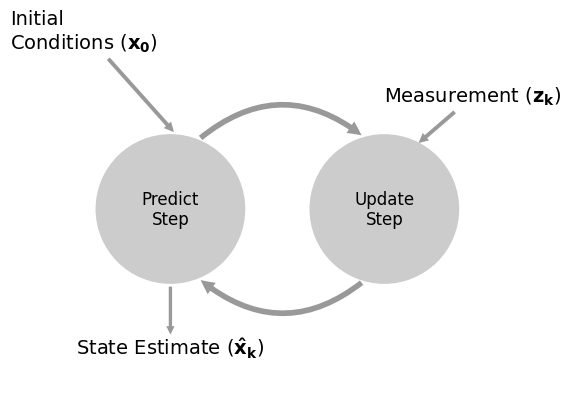

In [22]:
book_plots.predict_update_chart()

もう少し正式な用語を紹介しましょう。システムは推定する対象です。この章では、システムとは私たちが秤量しようとしているものです。いくつかのテキストではこれを植物と呼んでいます。この用語は制御システム理論から来ています。 https://en.wikipedia.org/wiki/Plant_(制御理論)

システムの状態とは、私たちが関心のあるシステムの現在の構成または値です。私たちは重量の読み取り値だけに興味があります。体重計に100kgの重りを乗せると100kgの状態になります。私たちは自分に関連するものに基づいて状態を定義します。スケールの色は私たちには無関係であるため、それらの値は状態に含めません。メーカーの QA エンジニアは、製造プロセスを追跡および制御できるように、状態に色を含める場合があります。

測定値はシステムの測定値です。測定値は不正確なため、状態と同じ値にならない場合があります。

状態推定値は、フィルターによる状態推定値です。たとえば、体重 100 kg の場合、センサーのエラーにより推定値が 99.327 kg になる可能性があります。これは一般に推定と略されますが、この章ではそれを行いました。

言い換えれば、状態はシステムの実際の値として理解される必要があります。この値は通常、私たちには隠されています。私が体重計に乗ったら、測定してもらえるでしょう。この測定値を直接観察できるため、これを観察可能と呼びます。対照的に、私の体重を直接観察することはできず、測定することしかできません。

**この隠されたものと観察可能なものという言語は重要です。あらゆる推定問題は、観察可能な測定を通じて隠れた状態の推定を形成することから構成されます。**文献を読む場合、これらの用語は問題を定義するときに使用されるため、これらの用語に慣れておく必要があります。

プロセス モデルを使用してシステムを数学的にモデル化します。この章では、プロセス モデルは、今日の体重が昨日の体重に前日の体重増加を加えたものであると仮定しています。プロセス モデルはセンサーをモデル化したり、その他の方法でセンサーを考慮したりすることはありません。別の例としては、自動車のプロセス モデルがあります。プロセス モデルは、「距離と速度の積に等しい」となる可能性があります。車の速度はゼロ以外の時間にわたって変化する可能性があり、タイヤが道路上でスリップする可能性があるため、このモデルは完璧ではありません。システム エラーまたはプロセス エラーは、このモデルのエラーです。この値を正確に知ることはできません。もし知っていれば、モデルを改良してエラーをゼロにすることができます。一部のテキストでは、プラント モデルとプラント エラーが使用されています。システム モデルも表示される場合があります。これらはすべて同じ意味です。もの。

予測ステップはシステム伝播として知られています。プロセス モデルを使用して、新しい状態推定を作成します。プロセスエラーのため、この推定は不完全です。データを長期にわたって追跡していると仮定すると、その状態を将来に伝播すると言えます。一部のテキストではこれを進化と呼んでいます。

更新ステップは、測定更新として知られています。システムの伝播と測定の更新の 1 回の繰り返しは、エポックとして知られています。

次に、このアルゴリズムをより深く理解するために、いくつかの異なる問題領域を検討してみましょう。線路上の列車を追跡しようとする問題を考えてみましょう。線路は列車の位置を非常に特定の領域に制限します。また、電車は大きくて遅いです。速度が大幅に低下したり、大幅に加速したりするまでに何分もかかります。したがって、列車が時刻 t にキロメートルマーカー 23 km にあり、時速 18 km で移動していることがわかっていれば、時刻 t + 1 秒における列車の位置を非常に自信を持って予測できます。それがなぜ重要なのでしょうか?その位置を次の精度でしか測定できないと仮定します。

250メートル。電車は時速18キロ、つまり秒速5メートルで走っています。 t+1 秒で列車の速度は 23.005 km になりますが、測定値は 22.755 km から 23.255 km の範囲になる可能性があります。したがって、次の測定で位置が 23.4 であることが示された場合、それは不正確であることがわかります。時刻 t で機関士がブレーキを踏んだとしても、列車は 1 秒以内にあまり減速できないため、列車の速度は依然として 23.005 km に非常に近いことになります。この問題に対応するフィルターを設計する場合 (この章ではもう少し詳しく説明します)、測定よりも予測に非常に高い重みを与えるフィルターを設計したいと思うでしょう。

次に、投げられたボールを追跡する問題を考えてみましょう。弾道物体は重力場内では真空中で放物線を描いて移動することがわかっています。しかし、地球上で投げられたボールは空気抵抗の影響を受けるため、完全な放物線を描いて進みません。野球の投手はこの事実を利用してカーブボールを投げます。私が仕事で行っているコンピュータービジョンを使用してスタジアム内のボールを追跡しているとします。コンピューター ビジョンによる追跡の精度はそれほど高くないかもしれませんが、ボールが放物線上を移動していると仮定してボールの将来の位置を予測することも、それほど正確であるとは言えません。この場合、おそらく測定と予測にほぼ同じ重みを与えるフィルターを設計するでしょう。

ここで、ハリケーンの中でヘリウム パーティーの風船を追跡しようと考えてみましょう。非常に短い時間スケールを除いて、気球の挙動を予測できる正当なモデルはありません (たとえば、気球が 1 秒で 10 マイル進むことができないことはわかっています)。この場合、予測よりも測定値を強調するフィルターを設計します。

この本のほとんどは、最後の 3 つの段落の懸念を数学的に表現することに専念しており、それによって (数学的な意味で) 最適な解決策を見つけることができます。この章では、単に異なる値gとhを代入するだけです。より直観的であり、したがってあまり最適ではない方法で。しかし、基本的な考え方は、ある程度不正確な測定値と、システムの動作に関する多少不正確なモデルを組み合わせて、いずれかの情報ソース単独よりも優れたフィルター処理された推定値を取得することです。

これをアルゴリズムとして表現できます。

```
Initialization

1. Initialize the state of the filter
2. Initialize our belief in the state

Predict

1. Use system behavior to predict state at the next time step
2. Adjust belief to account for the uncertainty in prediction

Update

1. Get a measurement and associated belief about its accuracy
2. Compute residual between estimated state and measurement
3. New estimate is somewhere on the residual line

```

多少の変更はありますが、本書全体でこれと同じアルゴリズムを使用します。

表記

文献で使用されている表記法と変数名を紹介していきます。この一部は上記のグラフですでに使用されています。測定値は通常 $z$ で表され、本書でもそれを使用します (一部の文献では $y$ が使用されています)。添字 $k$ は時間ステップを示すため、$z_k$ はこの時間ステップのデータです。太字のフォントはベクトルまたは行列を示します。これまでのところ、1 つのセンサー、つまり 1 つのセンサー測定のみを検討してきましたが、一般的には、$n$ センサーと $n$ 測定が存在する可能性があります。 $\mathbf{X}$ は状態を表し、それがベクトルであることを太字で示しています。この体重計の例では、次のように初期体重と初期体重増加率の両方を表します。
$$
\mathbf{x}=\left[\begin{array}{c}
x \\
\dot{x}
\end{array}\right]
$$

ここでは、$x$ 上の点のニュートン表記を使用して速度を示します。より正確には、ドットは、時間に関する $x$ の導関数 (もちろん速度) を意味します。 $62 \mathrm{~kg}$ の体重と $0.3 \mathrm{~kg} /$ 日の増加の場合、次のようになります。
$$
\mathbf{x}=\left[\begin{array}{c}
62 \\
0.3
\end{array}\right]
$$

したがって、アルゴリズムは単純です。状態は、初期推定値 $\mathbf{x}_{\mathbf{0}}$ で初期化されます。次にループに入り、時間 (またはステップ) $k-1$ の値から時間またはステップ $k$ の状態を予測します。次に、測定値 $z_k$ を取得し、測定値と予測の間の中間点を選択して、推定値 $\mathbf{x}_k$ を作成します。

演習: 汎用アルゴリズムを作成する

上の例では、この章全体で説明してきた重み付けの問題を解決するために、これを明示的にコーディングしました。たとえば、変数には「weight_scale」、「gain」などの名前が付けられます。アルゴリズムを理解しやすくするためにこれを行いました。各ステップが正しく実装されていることが簡単にわかります。ただし、これは 1 つの問題に対して書かれたコードであり、アルゴリズムはどの問題に対しても同じです。そこで、どんな問題にも対処できるように、コードを汎用的に書き直しましょう。この関数シグネチャを使用します。

In [23]:
def g_h_filter(data, x0, dx, g, h, dt):
    """
    固定の g と h を使用して 1 つの状態変数に対して g-h フィルターを実行します。
 
   「data」にはフィルタリングするデータが含まれます。
   「x0」は状態変数の初期値
   「dx」は状態変数の初期変化率
   「g」は g-h の g スケール係数
   「h」は g-h の h スケール係数
   「dt」はタイムステップの長さ 
    
    """

データをリストではなく NumPy 配列として返します。以前と同じ重量データを渡してテストし、結果をプロットして、機能することを視覚的に判断します。

[158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
[159.2   161.8   162.1   160.78  160.985 163.311 168.1   169.696
 168.204 169.164 170.892 172.629]


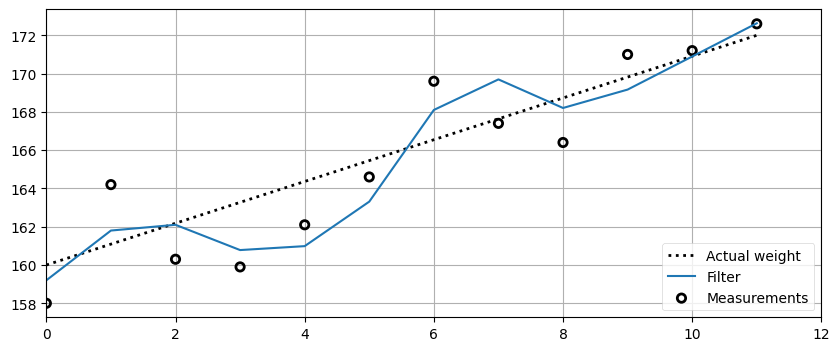

In [24]:
import matplotlib.pylab as pylab

def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        # 予測ステップ
        x_pred = x_est + (dx*dt)
        dx = dx
        
        # 更新ステップ
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
gh.plot_g_h_results(weights, data)
print(weights)
print(data)

これは簡単なはずでした。重量増加コードの変数名を x0、dx などに置き換えただけです。他に変更する必要はありません。

### $g$ と $h$ の選択

$\mathrm{g}$ - $\mathrm{h}$ フィルターは 1 つのフィルターではなく、フィルターのファミリーの分類です。 Eli Brookner は、『Tracking and Kalman Filtering Made Easy』の中で 11 件を挙げていますが、他にもあると思います。それだけでなく、各タイプのフィルターには多数のサブタイプがあります。各フィルターは、$g$ と $h$ がどのように選択されるかによって区別されます。したがって、ここで私が提供できる「万能の」アドバイスはありません。 $g$ と $h$ を定数として設定するフィルターもあれば、それらを動的に変更するフィルターもあります。カルマン フィルターは、各ステップで動的にそれらを変化させます。一部のフィルターでは、$g$ と $h$ が範囲内の任意の値を取ることができますが、他のフィルターでは、関数 $f(\cdot)$ ($g=f(h)$) によって一方が他方に依存するように制限されます。

この本の主題は、$\mathrm{g}$-h フィルターのファミリー全体ではありません。さらに重要なのは、これらのフィルターのベイジアン的な側面に興味があるということですが、これについてはまだ触れていません。したがって、$g$ と $h$ の選択については詳しく説明しません。 『Tracking and Kalman Filtering Made Easy』は、このトピックに関する優れたリソースです。私の立場が奇妙だと思われる方は、カルマン フィルターの典型的な定式化では $g$ と $h$ がまったく使用されていないことを認識してください。カルマン フィルターは、数学的にこのアルゴリズムに帰着するため、g-h フィルターです。カルマン フィルターを設計するとき、数学的に $g$ と $h$ に還元できる設計基準を使用しますが、通常、カルマン フィルター形式は問題を考えるためのより強力な方法です。現時点ではこれがあまり明確でなくても心配する必要はありません。カルマン フィルター理論を開発すればすぐに明確になります。

$g$ と $h$ の変化が結果にどのような影響を与えるかを見るのは価値があるので、いくつかの例を見てみましょう。これにより、このタイプのフィルターの基本的な長所と限界についての深い洞察が得られ、より洗練されたカルマン フィルターの動作を理解するのに役立ちます。

演習: 測定関数を作成する

次に、ノイズの多いデータを生成する関数を作成しましょう。この本では、ノイズを含む信号を信号とホワイト ノイズとしてモデル化します。ホワイト ノイズの定義を完全に理解するための統計についてはまだ説明していません。本質的には、パターンのない信号よりも上下にランダムに変化するデータと考えてください。これは、平均がゼロで分散が有限である系列無相関の確率変数であると言えます。これに従わない場合は、ガウスの章が終わるまでに従わなければなりません。統計の知識がない場合、この演習は成功しない可能性があります。その場合は、解決策と議論を読んでください。

ホワイトノイズはnumpyで生成できます。ランダム。ランドン（）。開始値、ステップごとの変化量、ステップ数、追加するノイズの量を指定して呼び出す関数が必要です。データのリストが返されるはずです。 30 個のポイントを作成し、 g_h_filter( ) でフィルタリングして、結果を plot_g_h_results() でプロットすることでテストします。

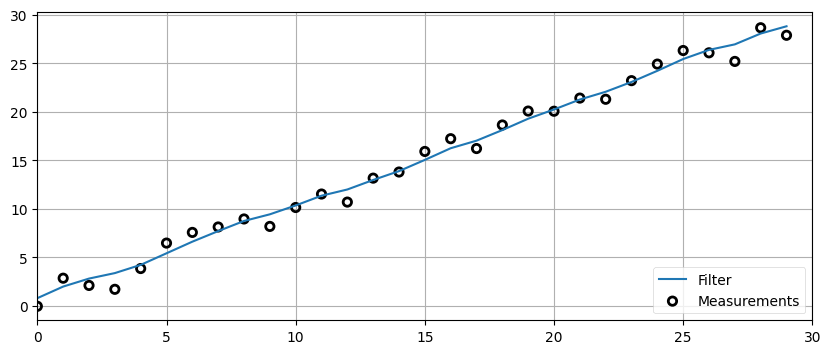

In [25]:
from numpy.random import randn

def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + randn()*noise_factor for i in range(count)]

measurements = gen_data(0, 1, 30, 1)
data = g_h_filter(data=measurements, x0=0., dx=1., dt=1., g=.2, h=0.02)
gh.plot_g_h_results(measurements, data)

議論

randn() は 0 を中心とする乱数を返します。乱数は、0 未満である場合と同じくらい、0 よりも大きい可能性があります。それは 1 標準偏差によって異なります。それが何を意味するか分からなくても心配する必要はありません。 randn() への 3000 回の呼び出しをプロットしました。値は 0 を中心としており、ほとんどの場合は -1 を少し下回る値から +1 を少し超える値までの範囲にありますが、場合によってはそれよりも大きくなる場合もあります。

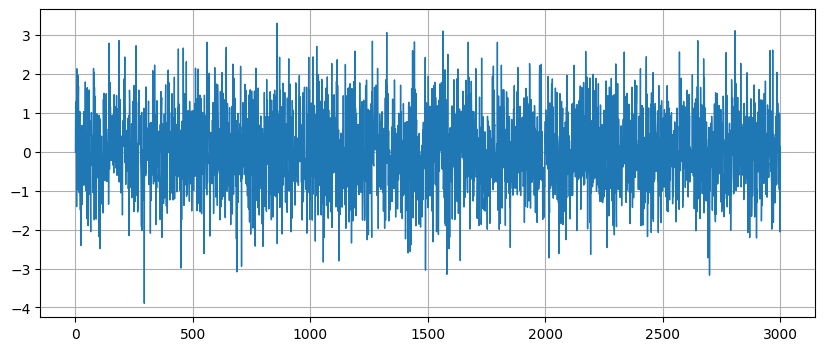

In [26]:
plt.plot([randn() for _ in range(3000)], lw=1);

演習: 悪い初期条件

ここで、gen_data と g_h_filter を使用して、5 から始まり、導関数が 2、ノイズ スケーリング係数が 10 で、g=0.2 と h=0.02 を使用する 100 個のデータ ポイントをフィルタリングするコードを作成します。 x の最初の推定値を 100 に設定します。

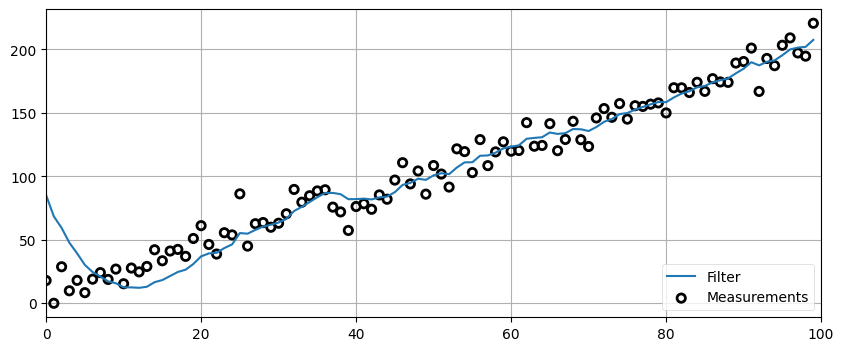

In [27]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.02)
gh.plot_g_h_results(measurements=zs, filtered_data=data)

フィルターは、初期推定値 100 が不適切なため、測定データからかけ離れた推定値で開始されます。測定データに落ち着く前にフィルターが「鳴る」ことがわかります。 「リンギング」とは、信号が正弦波タイプのパターンでデータをオーバーシュートおよびアンダーシュートすることを意味します。これはフィルターでは非常に一般的な現象であり、フィルター設計ではリンギングを最小限に抑えるために多大な労力が費やされます。これは私たちがまだ取り組む準備ができていないトピックですが、その現象をお見せしたいと思いました。


演習: 極端な騒音

同じテストを再実行しますが、今回はノイズ係数 100 を使用します。初期条件を 100 から 5 に変更して、初期条件のリンギングを除去します。

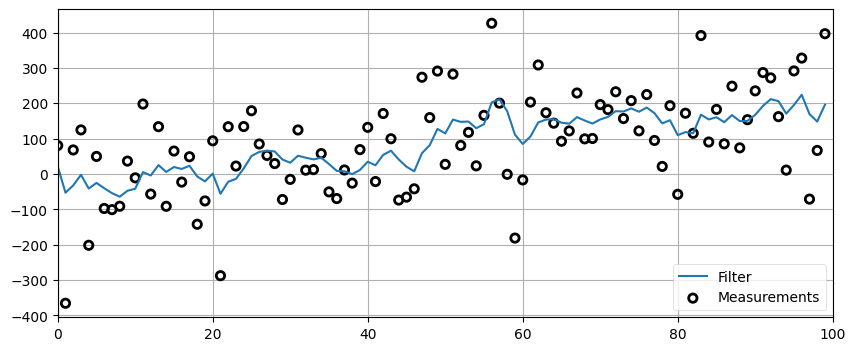

In [28]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=2., g=0.2, h=0.02)
gh.plot_g_h_results(measurements=zs, filtered_data=data)

これは私にはそれほど素晴らしいようには見えません。おそらくフィルタリングされた信号はノイズのある信号よりも変化が少ないことがわかりますが、直線からは程遠いです。フィルター処理された結果だけをプロットした場合、信号が 5 で始まり、タイム ステップごとに 2 ずつ増加することは誰も推測しません。また、ある場所ではフィルターがノイズを低減しているように見えますが、他の場所ではオーバーシュートやアンダーシュートが発生しているように見えます。

現時点では、これを実際に判断するのに十分な知識がありません。たくさんのノイズを追加しました。おそらくこれは、フィルタリングが可能な限り優れたものです。しかし、この章以外にも多数の章が存在することは、私たちがさらに改善できることを示唆しているはずです。

演習: 加速の効果

各データ ポイントに一定の加速係数を追加する新しいデータ生成関数を作成します。言い換えれば、速度 ( $\mathrm{dx}$ ) が増加し続けるように、各データ点を計算するときに $\mathrm{dx}$ を増分します。ノイズを $0、g=0.2$、$h=\mathbf{0 に設定します。 0 2}$ を実行し、plot_g_h_results または独自のルーチンを使用して結果をプロットします。さまざまな加速とタイムステップを試してみましょう。あなたが見ているものを説明してください。

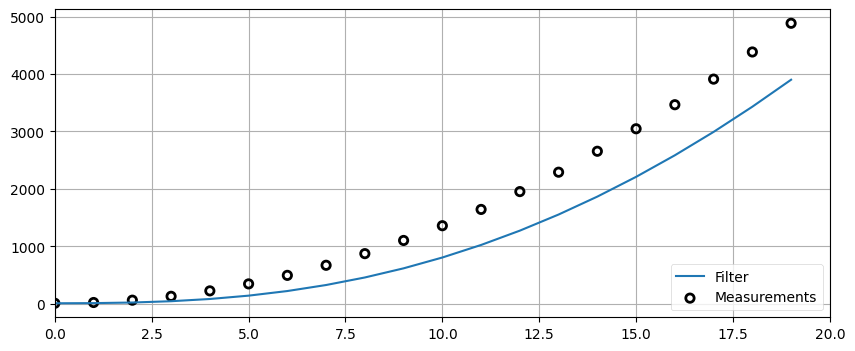

In [29]:
def gen_data(x0, dx, count, noise_factor, accel=0.):
    zs = []
    for i in range(count):
        zs.append(x0 + accel* (i**2) / 2 + dx*i + randn()*noise_factor)
        dx += accel
    return zs
    
predictions = []
zs = gen_data(x0=10., dx=0., count=20, noise_factor=0, accel=9.)
data = g_h_filter(data=zs, x0=10., dx=0., g=0.2, h=0.02)
gh.plot_g_h_results(measurements=zs, filtered_data=data)

各予測は信号の遅れを追いかけています。これについて考えると、これは理にかなっています。モデルは速度が一定であると仮定しています。g-hフィルタは$x$の一次導関数（$\dot{x}$で導関数を示す）を計算しますが、二次導関数$\ddot{x}$は計算しません。したがって、$\ddot{x}=0$と仮定しています。各予測ステップで、新しい$x$の値を$x + \dot{x}*t$として予測します。しかし、加速度があるため、予測は必然的に実際の値よりも遅れます。その後、新しい$\dot{x}$の値を計算しようとしますが、$h$の要因により、$\dot{x}$は新しい速度に部分的にしか調整されません。次の反復ではまた遅れをとります。

この問題を修正するために調整できる$g$や$h$は存在しません。これはシステムの「ラグエラー」または「系統誤差」と呼ばれます。これはg-hフィルタの基本的な特性です。おそらく、あなたの考えが既にこの問題への解決策や回避策を示唆しています。この問題には多くの研究が行われており、この本ではこの問題へのさまざまな解決策を紹介していきます。

> 重要なポイントは、フィルタはシステムを表現するために使用される数学モデルの優れたものである限りにおいてのみ優れている、ということです。

## 練習問題: $g$ の変化
さて、$g$ を変化させることの影響を見てみましょう。この練習問題を実行する前に、$g$ が測定値と予測値の選択におけるスケールファクターであることを思い出してください。$g$ の大きな値の影響と小さな値の影響について、どのような効果があると考えますか？

そして、`noise_factor=50` および `dx=5` としましょう。$g = 0.1\mbox{, } 0.4,\mbox{ および } 0.8$ の結果をプロットしてみてください。

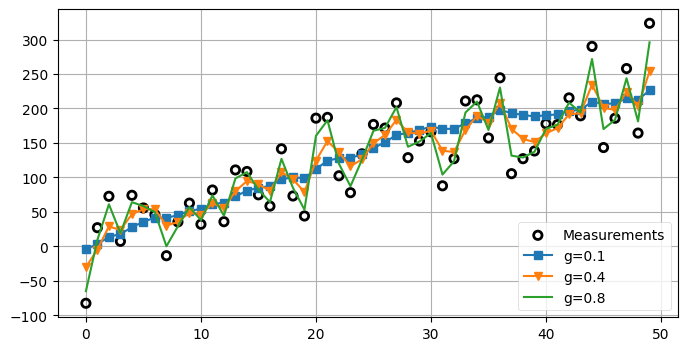

In [30]:
np.random.seed(100)
zs = gen_data(x0=5., dx=5., count=50, noise_factor=50)
data1 = g_h_filter(data=zs, x0=0., dx=5, dt=1, g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=0., dx=5, dt=1, g=0.4, h=0.01)
data3 = g_h_filter(data=zs, x0=0., dx=5, dt=1, g=0.8, h=0.01)

with book_plots.figsize(y=4):
    book_plots.plot_measurements(zs, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
    book_plots.plot_filter(data2, label='g=0.4', marker='v', c='C1')
    book_plots.plot_filter(data3, label='g=0.8', c='C2')
    plt.legend(loc=4)

$g$が大きいほど、予測ではなく測定値に密接に従うことがより明確です。$g=0.8$の場合、信号をほぼ正確に追い、ノイズをほとんど拒否しません。素直には$g$を常に非常に小さくすればノイズの拒否が最大化されると結論づけるかもしれませんが、それでは予測よりも測定値を無視していることになります。信号がノイズではなく実際の状態変化によって変化する場合、どうなるでしょうか。見てみましょう。$\dot{x}=1$のデータを9ステップ続けた後に$\dot{x}=0$に変化するデータを作成します。

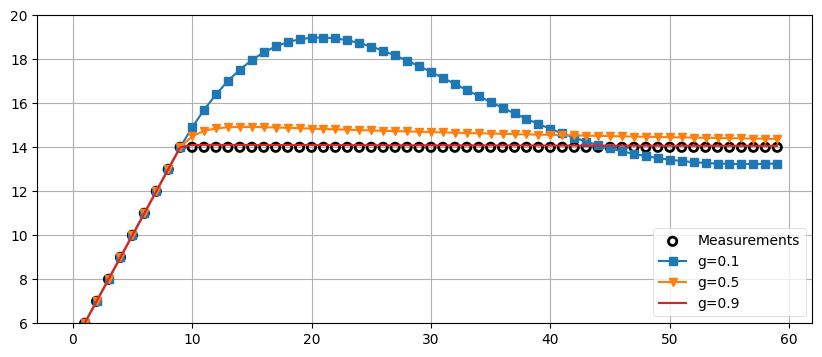

In [31]:
zs = [5,6,7,8,9,10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)
    
data1 = g_h_filter(data=zs, x0=4., dx=1, dt=1, g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=4., dx=1, dt=1, g=0.5, h=0.01)
data3 = g_h_filter(data=zs, x0=4., dx=1, dt=1, g=0.9, h=0.01)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
book_plots.plot_filter(data2, label='g=0.5', marker='v', c='C1')
book_plots.plot_filter(data3, label='g=0.9', c='C3')
plt.legend(loc=4)
plt.ylim([6, 20]);

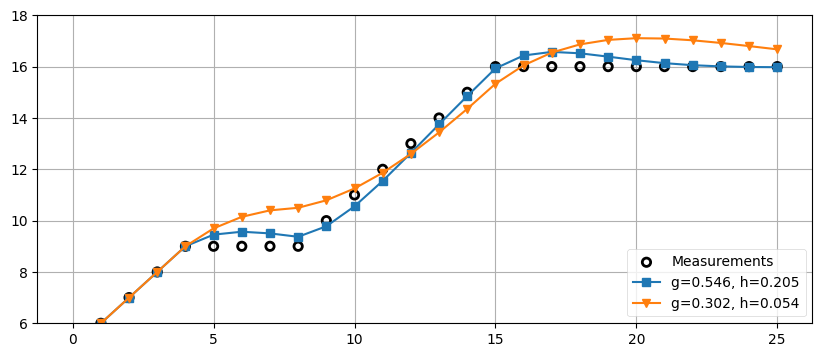

In [32]:
zs = [5,6,7,8,9,9,9,9,9,10,11,12,13,14,
      15,16,16,16,16,16,16,16,16,16,16,16,]
data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.302, h=.054)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.546, h=.205)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data2, label='g=0.546, h=0.205', marker='s', c='C0')
book_plots.plot_filter(data1, label='g=0.302, h=0.054', marker='v', c='C1')
plt.legend(loc=4)
plt.ylim([6, 18]);

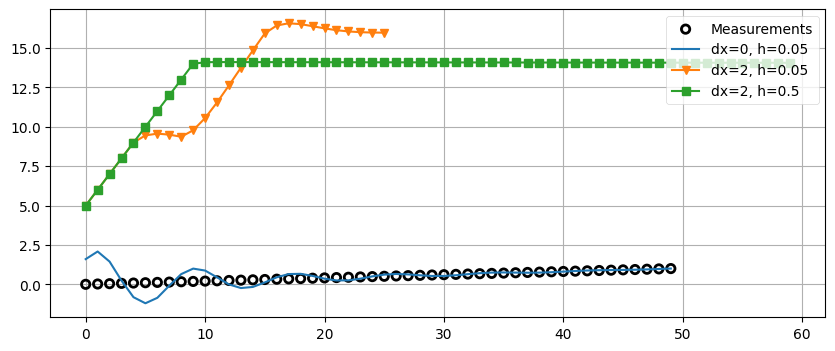

In [33]:
zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data1 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data1 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05', c='C0')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v', c='C1')
book_plots.plot_filter(data3, label='dx=2, h=0.5', marker='s', c='C2')

plt.legend(loc=1);

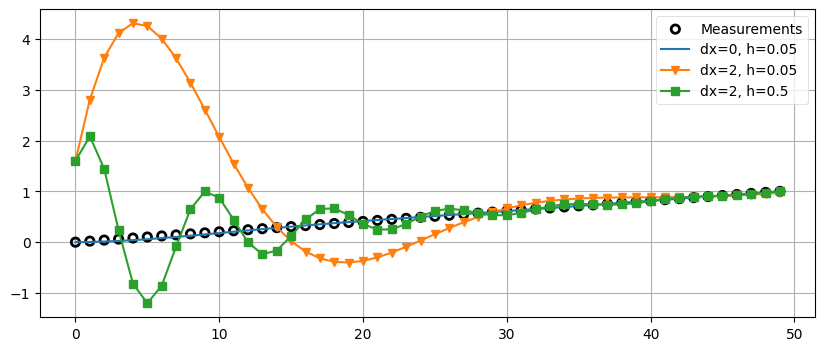

In [34]:


zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05', c='C0')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v', c='C1')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s', c='C2')
plt.legend(loc=1);



In [35]:
from ipywidgets import interact
from kf_book.book_plots import FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

def interactive_gh(x, dx, g, h):
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k',
               facecolors='none', marker='o', lw=1)
    plt.plot(data, color='b')
    plt.show()
    
interact(interactive_gh,
        x=FloatSlider(value=0, min=-200, max=200),
        dx =FloatSlider(value=5, min=-50, max=50),
        g=FloatSlider(value=.1, min=.01, max=2, step=.02),
        h=FloatSlider(value=.02, min=.0, max=.5, step=.01));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=200.0, min=-200.0),…

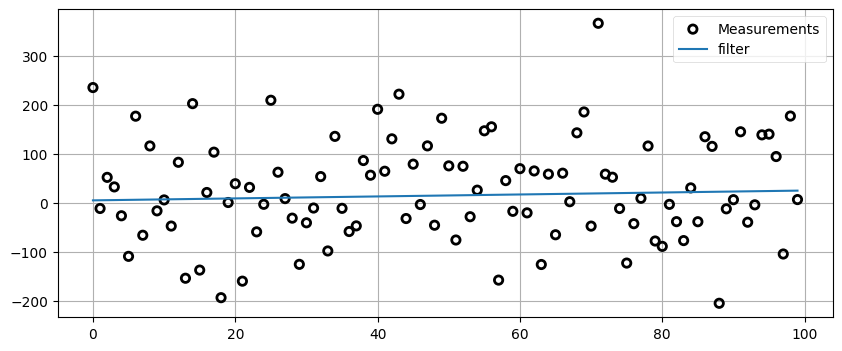

In [36]:
zs =gen_data(x0=5., dx=.2, count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=.2, dt=1., g=0., h=0.)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data,label='filter')
plt.legend(loc=1);

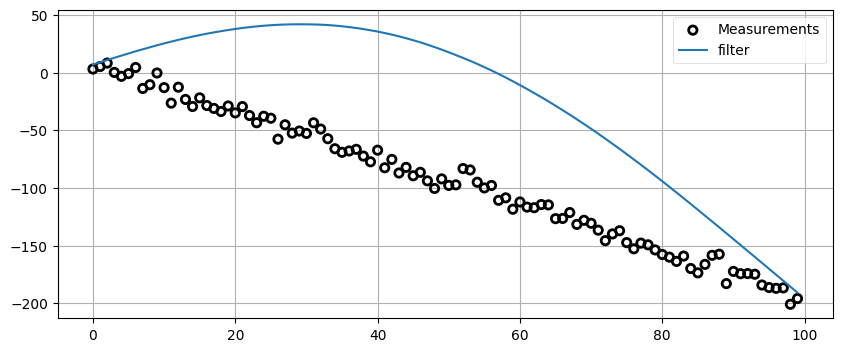

In [37]:
zs = gen_data(x0=5, dx=-2, count=100, noise_factor=5)
data = g_h_filter(data=zs, x0=5., dx=2., dt=1., g=.005, h=0.001)
book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

In [38]:
pos = 23*1000
vel = 15

In [39]:
def compute_new_position(pos, vel, dt=1):
    return pos + (vel*dt)

In [40]:
def measure_position(pos):
    return pos + random.randn()*500

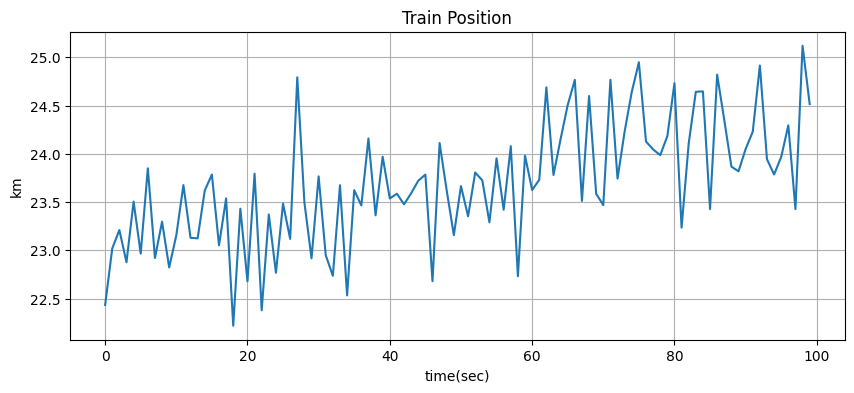

In [41]:
from numpy.random import randn

def compute_new_position(pos, vel, dt=1):
    """dtは時間差分(単位は秒)"""
    return pos + (vel * dt)

def measure_position(pos):
    return pos + randn()*500

def gen_train_data(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        zs.append(measure_position(pos))
    return np.asarray(zs)

pos, vel = 23.*1000, 15.
zs = gen_train_data(pos, vel, 100)

plt.plot(zs/1000.) #　キロメートルに変換する
book_plots.set_labels('Train Position', 'time(sec)', 'km')

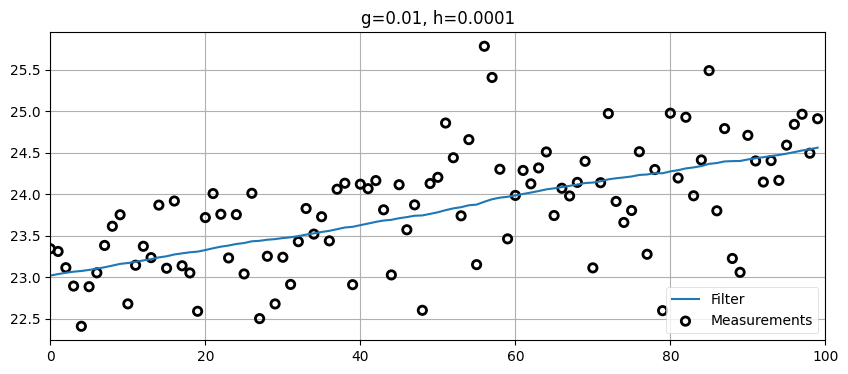

In [42]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
gh.plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

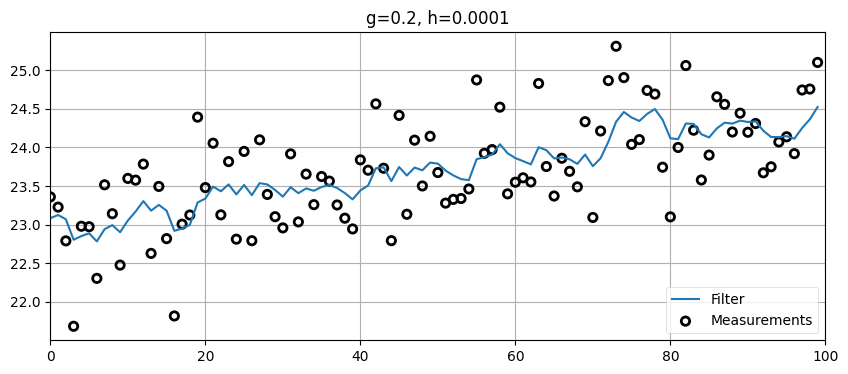

In [43]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.2, h=0.0001)
gh.plot_g_h_results(zs/1000., data/1000., 'g=0.2, h=0.0001')

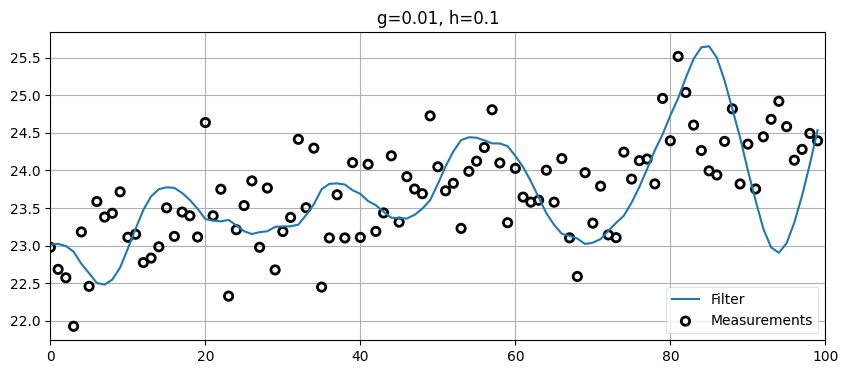

In [44]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.1)
gh.plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.1')

In [45]:
def gen_train_data_with_acc(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos,vel)
        vel += 0.2
        zs.append(measure_position(pos))
    return np.asarray(zs)

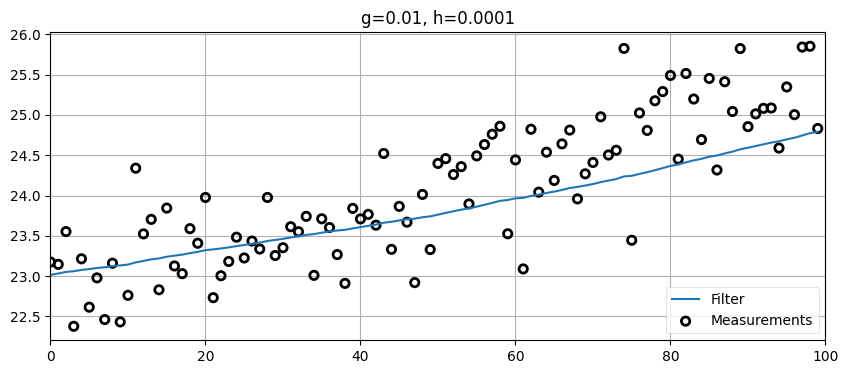

In [46]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
gh.plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

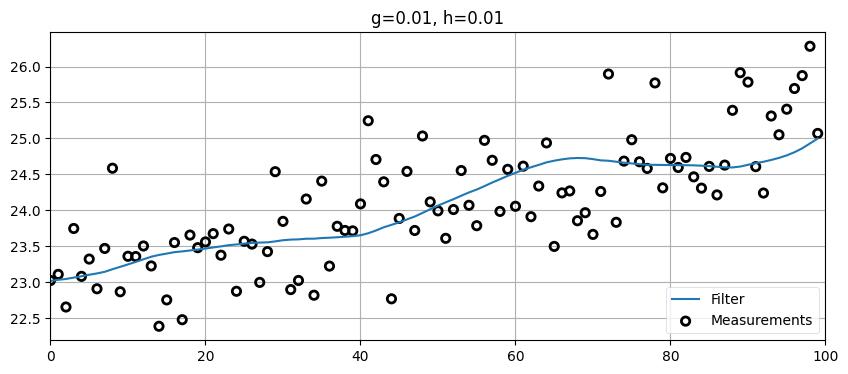

In [47]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.01)
gh.plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.01')

In [48]:
!pip install filterpy

In [49]:
from filterpy.gh import GHFilter
f = GHFilter(x=0., dx=0., dt=1., g=.8, h=.2)

In [50]:
f.update(z=1.2)

(0.96, 0.24)

In [52]:
print(f.update(z=2.1, g=.85, h=.15))

(1.965, 0.375)


In [53]:
print(f.batch_filter([3., 4., 5.]))

[[1.965 0.375]
 [2.868 0.507]
 [3.875 0.632]
 [4.901 0.731]]


In [54]:
x_0 = np.array([1., 10., 100.])
dx_0 = np.array([10., 12., .2])

f_air = GHFilter(x=x_0, dx=dx_0, dt=1., g=.8, h=.2)
f_air.update(z=np.array((2., 11., 102.)))
print('x = ', f_air.x)
print('dx =', f_air.dx)

x =  [  3.8   13.2  101.64]
dx = [8.2  9.8  0.56]
